In [0]:
%pip install vaderSentiment textblob nltk
%pip install datasets
%pip install transformers
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install tensorflow
%pip install praw
%pip install tf-keras
%pip install gensim spacy nltk wordcloud
%pip install spacy
%pip install inflect
%pip install nltk
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md

  Obtaining dependency information for vaderSentiment from https://files.pythonhosted.org/packages/76/fc/310e16254683c1ed35eeb97386986d6c00bc29df17ce280aed64d55537e9/vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/1e/d6/40aa5aead775582ea0cf35870e5a3f16fab4b967f1ad2debe675f673f923/textblob-0.19.0-py3-none-any.whl.metadata
  Obtaining dependency information for nltk from https://files.pythonhosted.org/packages/4d/66/7d9e26593edda06e8cb531874633f7c2372279c3b0f46235539fe546df8b/nltk-3.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/ee/2e/c689f274a92deffa03999a430505ff2aeace408fd681a90eafa92fdd6930/regex-2025.7.34-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/40.5 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [0]:
dbutils.library.restartPython()

## Posts DF

In [0]:
import os, time, math
from datetime import datetime
import pandas as pd
import praw


reddit = praw.Reddit(
    client_id="[REDACTED]",
    client_secret="[REDACTED]",
    user_agent="test_sent"
)

# ---------- Config ----------
SUBREDDITS = ["BritishProblems", "AskUK", "UnitedKingdom", "UKPolitics"]

# Mix of listings to cover recent + historic + trending
STREAMS = {
    "hot":           {"fn": "hot",           "limit": 500},
    "new":           {"fn": "new",           "limit": 800},
    "rising":        {"fn": "rising",        "limit": 200},
    "top_day":       {"fn": "top",           "limit": 400, "time_filter": "day"},
    "top_week":      {"fn": "top",           "limit": 600, "time_filter": "week"},
    "top_month":     {"fn": "top",           "limit": 800, "time_filter": "month"},
    "top_year":      {"fn": "top",           "limit": 1000,"time_filter": "year"},
    "top_all":       {"fn": "top",           "limit": 1000,"time_filter": "all"},
    "contro_week":   {"fn": "controversial", "limit": 300, "time_filter": "week"},
    "contro_year":   {"fn": "controversial", "limit": 600, "time_filter": "year"},
}

# Targeted keyword queries 
SEARCH_QUERIES = [
    "emigrate OR emigration",
    "\"leave the UK\" OR \"leaving the UK\"",
    "move abroad OR moving abroad OR relocation",
    "visa OR work permit OR sponsorship",
    "cost of living OR housing OR rent OR salary",
    "NHS OR doctor OR nurse OR healthcare job",
]
SEARCH_LIMIT_PER_QUERY = 300  # per subreddit per query

MIN_DATE = "2016-01-01"  # or None
MIN_TS = int(datetime.strptime(MIN_DATE, "%Y-%m-%d").timestamp()) if MIN_DATE else None
SLEEP = 0.6  


# ---------- Helpers ----------
def to_row(sub, sr_name):
    dt = datetime.utcfromtimestamp(sub.created_utc)
    return {
        "id": sub.id,
        "subreddit": sr_name,
        "title": sub.title or "",
        "selftext": sub.selftext or "",
        "author": str(sub.author) if sub.author else "[deleted]",
        "score": sub.score,
        "num_comments": sub.num_comments,
        "created_utc": sub.created_utc,
        "created_dt": dt.strftime("%Y-%m-%d %H:%M:%S"),
        "permalink": f"https://www.reddit.com{sub.permalink}",
        "url": sub.url,
        "flair": sub.link_flair_text,
        "over_18": sub.over_18,
        "locked": sub.locked,
        "distinguished": sub.distinguished
    }

def add_batch(iterable, sr_name, seen, out):
    new_count = 0
    for sub in iterable:
        if MIN_TS and sub.created_utc < MIN_TS:
            # skip older than desired window
            continue
        if sub.id in seen:
            continue
        seen.add(sub.id)
        out.append(to_row(sub, sr_name))
        new_count += 1
    return new_count

all_rows, seen_ids = [], set()

for sr in SUBREDDITS:
    subreddit = reddit.subreddit(sr)
    print(f"\n📥 r/{sr}")

    # 1) Listings (hot/new/top/rising/controversial)
    for name, cfg in STREAMS.items():
        try:
            fetch_fn = getattr(subreddit, cfg["fn"])
            kwargs = {"limit": cfg["limit"]}
            if "time_filter" in cfg:
                kwargs["time_filter"] = cfg["time_filter"]
            batch = fetch_fn(**kwargs)
            added = add_batch(batch, sr, seen_ids, all_rows)
            print(f"  • {name:<12} +{added} (limit={cfg['limit']})")
            time.sleep(SLEEP)
        except Exception as e:
            print(f"  • {name:<12} skipped: {e}")

    # 2) Searches (broad coverage beyond listings)
    for q in SEARCH_QUERIES:
        try:
            batch = subreddit.search(q, sort="relevance", time_filter="all", limit=SEARCH_LIMIT_PER_QUERY)
            added = add_batch(batch, sr, seen_ids, all_rows)
            print(f"  • search [{q[:28]}...] +{added} (limit={SEARCH_LIMIT_PER_QUERY})")
            time.sleep(SLEEP)
        except Exception as e:
            print(f"  • search [{q[:28]}...] skipped: {e}")

df = pd.DataFrame(all_rows)

# Drop NSFW or locked posts if desired
df = df[(~df["over_18"]) & (~df["locked"])]

# Remove truly empty content
df = df[(df["title"].str.strip() != "") | (df["selftext"].str.strip() != "")]
df.reset_index(drop=True, inplace=True)

df["total_text"] = df["title"] + " " + df["selftext"]


It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📥 r/BritishProblems


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • hot          +500 (limit=500)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • new          +300 (limit=800)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • rising       +0 (limit=200)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • top_day      +0 (limit=400)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • top_week     +0 (limit=600)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • top_month    +0 (limit=800)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_year     +989 (limit=1000)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_all      +773 (limit=1000)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • contro_week  +0 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • contro_year  +474 (limit=600)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [emigrate OR emigration...] +12 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search ["leave the UK" OR "leaving t...] +2 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [move abroad OR moving abroad...] +126 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [visa OR work permit OR spons...] +128 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [cost of living OR housing OR...] +160 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [NHS OR doctor OR nurse OR he...] +125 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📥 r/AskUK


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • hot          +500 (limit=500)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • new          +301 (limit=800)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • rising       +0 (limit=200)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • top_day      +0 (limit=400)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_week     +0 (limit=600)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_month    +584 (limit=800)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_year     +976 (limit=1000)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_all      +906 (limit=1000)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • contro_week  +0 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • contro_year  +599 (limit=600)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [emigrate OR emigration...] +130 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search ["leave the UK" OR "leaving t...] +96 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [move abroad OR moving abroad...] +157 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [visa OR work permit OR spons...] +150 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [cost of living OR housing OR...] +162 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [NHS OR doctor OR nurse OR he...] +156 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📥 r/UnitedKingdom


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • hot          +500 (limit=500)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • new          +300 (limit=800)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • rising       +0 (limit=200)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • top_day      +0 (limit=400)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • top_week     +0 (limit=600)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_month    +363 (limit=800)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_year     +971 (limit=1000)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_all      +864 (limit=1000)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • contro_week  +0 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • contro_year  +596 (limit=600)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [emigrate OR emigration...] +56 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search ["leave the UK" OR "leaving t...] +37 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [move abroad OR moving abroad...] +162 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [visa OR work permit OR spons...] +161 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [cost of living OR housing OR...] +188 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [NHS OR doctor OR nurse OR he...] +170 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




📥 r/UKPolitics


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • hot          +500 (limit=500)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • new          +300 (limit=800)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • rising       +0 (limit=200)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • top_day      +0 (limit=400)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_week     +0 (limit=600)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_month    +479 (limit=800)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_year     +979 (limit=1000)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • top_all      +815 (limit=1000)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • contro_week  +0 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  • contro_year  +595 (limit=600)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [emigrate OR emigration...] +91 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search ["leave the UK" OR "leaving t...] +64 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [move abroad OR moving abroad...] +173 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [visa OR work permit OR spons...] +159 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [cost of living OR housing OR...] +191 (limit=300)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



  • search [NHS OR doctor OR nurse OR he...] +166 (limit=300)

✅ Final unique submissions: 16,877
subreddit
AskUK              4565
UKPolitics         4494
UnitedKingdom      4335
BritishProblems    3483

Sample rows:
      subreddit          created_dt  score                                                                                                           title
BritishProblems 2025-06-18 21:10:43     12                                                                                  Reminder: Rule 4 - No Politics
BritishProblems 2025-08-25 11:41:08    357 After driving across Europe for the past week, I've realised middle lane hoggers are truly a British phenomenon
BritishProblems 2025-08-25 11:05:38    119                                                                              David Attenborough saying "Zeebra"
BritishProblems 2025-08-25 13:04:56     47                    A warm, sunny Bank Holiday being the best day for my neighbour to burn waste in their garden
British

## Sentiment Analysis

In [0]:

import nltk

nltk.download(
    'wordnet'
)

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [0]:
from gensim.models.phrases import Phrases, Phraser
from nltk.stem import WordNetLemmatizer
import inflect
from gensim.utils import simple_preprocess
from wordcloud import STOPWORDS as wc_stopwords

# Build a cleaner custom stopword set (deduped)
custom_stopwords = set(wc_stopwords).union({
    "uk","like","would","also","getting","got","get","go",
    "ll","ve","re","don","didn","isn","wasn","weren","day",
    "now","ask","want","know","think","say","said","saying","says","bn","email",
    "new","year","person","people","try","look","tell","thing","good","use","will",
    "see","back","come","one","really","i_am","i_don","take","put",
    "the_uk","feel","make","today","still","m_not","due_to","even", "wa", "thi", "ha",
    "seem", "we_re", "do_you", "etc", "https_www", "hi", "let", "would_be",
    "we_re", "hi", "do_you", "seem", "etc", "would_be"
})

lemmatizer = WordNetLemmatizer()
p = inflect.engine()

# Train bigrams on LOWER-CASED, tokenized text (better quality than .split())
sentences = df["total_text"].astype(str).apply(lambda x: simple_preprocess(x))
bigram = Phrases(sentences, min_count=5, threshold=10)
bigram_model = Phraser(bigram)

# Apply bigrams
df["bigram_text"] = sentences.apply(lambda toks: " ".join(bigram_model[toks]))

def preprocess(text: str):
    tokens = simple_preprocess(text)  # lower, deaccent, min_len=2 by default
    cleaned = []
    for t in tokens:
        # normalize first
        t_norm = p.singular_noun(t) or t      # persons/people -> person (when applicable)
        t_norm = lemmatizer.lemmatize(t_norm, 'n')
        t_norm = lemmatizer.lemmatize(t_norm, 'v')
        # THEN filter
        if t_norm not in custom_stopwords:
            cleaned.append(t_norm)
    return cleaned

df["processed_text_new"] = df["bigram_text"].apply(preprocess)


In [0]:
# Should be 0 if everything worked
sum("person" in toks for toks in df["processed_text_new"])


0

## Topic Modelling

In [0]:
spark_df = spark.createDataFrame(df)
spark_df.createOrReplaceTempView("test_df")

In [0]:
from nltk.corpus import stopwords
from gensim import corpora, models

In [0]:
import spacy

nlp = spacy.load("en_core_web_sm")

# Function to create meaningful bigrams based on POS tagging
def pos_based_bigrams(text):
    doc = nlp(text)  # Process text with spaCy
    tokens = [token.text for token in doc]  # Extract word tokens
    pos_tags = [token.pos_ for token in doc]  # Extract POS tags
    
    bigrams = []
    for i in range(len(tokens) - 1):
        word1, word2 = tokens[i], tokens[i + 1]
        tag1, tag2 = pos_tags[i], pos_tags[i + 1]
        
        # Allow bigrams for Proper Nouns, Adjective + Noun, or Noun + Noun
        if (tag1 == "PROPN" and tag2 == "PROPN") or \
           (tag1 == "ADJ" and tag2 == "NOUN") or \
           (tag1 == "NOUN" and tag2 == "NOUN"):
            bigrams.append(f"{word1}_{word2}")  # Merge words into bigram
        else:
            bigrams.append(word1)  # Keep single word

    # Add the last word (if not included in a bigram)
    bigrams.append(tokens[-1])

    return " ".join(bigrams)

# Apply POS-based bigram detection
df["bigram_text"] = df["total_text"].apply(pos_based_bigrams)

# Print example output
print(df["bigram_text"].head())


0    Reminder : Rule 4 - No_Politics Politics # # #...
1    After driving across Europe for the past_week ...
2    David_Attenborough Attenborough saying " Zeebra "
3    A warm , sunny Bank_Holiday Holiday being the ...
4    The fact that 4 G_data data never seems to wor...
Name: bigram_text, dtype: object


In [0]:
%python

# Create dictionary and corpus for Reddit posts
post_dictionary = corpora.Dictionary(df["processed_text_new"])
post_corpus = [post_dictionary.doc2bow(text) for text in df["processed_text_new"]]


# Train LDA model for Reddit posts
lda_model_posts = gensim.models.LdaModel(
    corpus=post_corpus,
    id2word=post_dictionary,
    num_topics=5,  # Adjust number of topics as needed
    random_state=42,
    passes=10
)


# Display top topics for Reddit posts
print("\n🔹 Top Topics in Reddit Comments:")
for idx, topic in lda_model_posts.print_topics(-1):
    print(f"Topic {idx}: {topic}")



🔹 Top Topics in Reddit Comments:
Topic 0: 0.015*"government" + 0.013*"labour" + 0.011*"vote" + 0.011*"brexit" + 0.009*"tory" + 0.009*"britain" + 0.007*"eu" + 0.006*"party" + 0.006*"bill_presented" + 0.006*"private_member"
Topic 1: 0.014*"work" + 0.013*"I" + 0.007*"time" + 0.007*"job" + 0.006*"need" + 0.004*"way" + 0.003*"child" + 0.003*"life" + 0.003*"question" + 0.003*"post"
Topic 2: 0.007*"man" + 0.007*"police" + 0.007*"woman" + 0.006*"move" + 0.006*"car" + 0.005*"call" + 0.005*"leave" + 0.005*"train" + 0.004*"drive" + 0.004*"stop"
Topic 3: 0.010*"I" + 0.008*"buy" + 0.005*"food" + 0.004*"time" + 0.004*"drink" + 0.004*"house" + 0.004*"eat" + 0.004*"shop" + 0.004*"work" + 0.003*"price"
Topic 4: 0.014*"move" + 0.013*"pay" + 0.013*"job" + 0.013*"I" + 0.012*"live" + 0.012*"cost_of" + 0.010*"work" + 0.010*"mp" + 0.009*"house" + 0.007*"cost"


Running LDA sweep...
k= 3  Cv=0.432  UMass=-2.635  Perplexity=364.7
k= 4  Cv=0.382  UMass=-3.151  Perplexity=370.5
k= 5  Cv=0.456  UMass=-3.929  Perplexity=393.8
k= 6  Cv=0.412  UMass=-4.335  Perplexity=417.3
k= 7  Cv=0.396  UMass=-3.724  Perplexity=429.4
k= 8  Cv=0.385  UMass=-4.248  Perplexity=458.5
k= 9  Cv=0.404  UMass=-3.917  Perplexity=490.9
k=10  Cv=0.384  UMass=-4.786  Perplexity=547.6
k=11  Cv=0.374  UMass=-4.206  Perplexity=678.2
k=12  Cv=0.404  UMass=-5.307  Perplexity=921.5


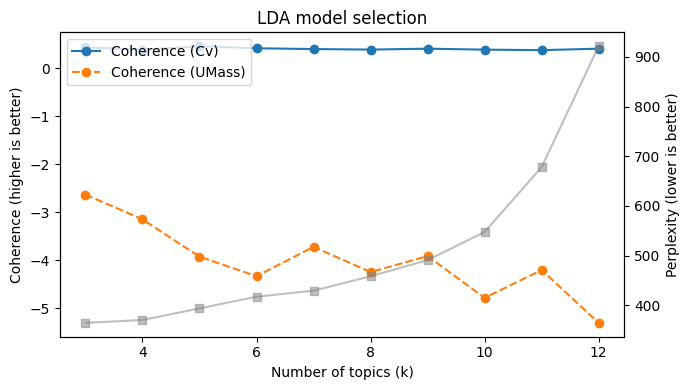


Suggested k by Cv peak: 5

Final model (k=5) overall coherence Cv = 0.456
 topic_id                                                  top_terms prevalence coherence_Cv
        1                 work, I, time, job, need, way, child, life      0.241        0.406
        3                I, buy, food, time, drink, house, eat, shop      0.224        0.521
        0 government, labour, vote, brexit, tory, britain, eu, party      0.183        0.426
        4                 move, pay, job, I, live, cost_of, work, mp      0.179        0.523
        2          man, police, woman, move, car, call, leave, train      0.173        0.407


In [0]:
%python
from gensim import corpora
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel


texts = df["processed_text_new"]         # tokenized, preprocessed list-of-lists
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(t) for t in texts]

# --- Config ---
K_RANGE = range(3, 13)  
RANDOM_STATE = 42
PASSES = 10             
ALPHA = 'symmetric'      
ETA = 'symmetric'

def fit_lda(k):
    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=RANDOM_STATE,
        passes=PASSES,
        alpha=ALPHA,
        eta=ETA,
        minimum_probability=0.0
    )

    perplexity = np.exp2(-model.log_perplexity(corpus))
    cm_cv = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    cv = cm_cv.get_coherence()
    cm_umass = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    umass = cm_umass.get_coherence()
    return model, cv, umass, perplexity

results = []
models = {}

print("Running LDA sweep...")
for k in K_RANGE:
    mdl, cv, umass, pplx = fit_lda(k)
    models[k] = mdl
    results.append({"k": k, "coherence_cv": cv, "coherence_umass": umass, "perplexity": pplx})
    print(f"k={k:>2}  Cv={cv:.3f}  UMass={umass:.3f}  Perplexity={pplx:.1f}")

res_df = pd.DataFrame(results)

# --- Plot coherence/perplexity vs k ---
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(res_df["k"], res_df["coherence_cv"], marker="o", label="Coherence (Cv)")
ax1.plot(res_df["k"], res_df["coherence_umass"], marker="o", linestyle="--", label="Coherence (UMass)")
ax1.set_xlabel("Number of topics (k)")
ax1.set_ylabel("Coherence (higher is better)")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(res_df["k"], res_df["perplexity"], marker="s", color="gray", alpha=0.5, label="Perplexity")
ax2.set_ylabel("Perplexity (lower is better)")
plt.title("LDA model selection")
plt.tight_layout()
plt.show()

best_k = int(res_df.loc[res_df["coherence_cv"].idxmax(), "k"])
print(f"\nSuggested k by Cv peak: {best_k}")

final_model = models[best_k]  # reuse trained model at best_k

# Topic prevalence (mean theta across docs)
doc_topic = np.array([
    [p for _, p in final_model.get_document_topics(bow, minimum_probability=0.0)]
    for bow in corpus
])
prevalence = doc_topic.mean(axis=0)

# Coherence per topic
cm_final = CoherenceModel(model=final_model, texts=texts, dictionary=dictionary, coherence='c_v')
coh_per_topic = cm_final.get_coherence_per_topic()
overall_cv = cm_final.get_coherence()

# Build a tidy table
def top_terms(model, topic_id, topn=8):
    return ", ".join([w for w, _ in model.show_topic(topic_id, topn=topn)])

summary = pd.DataFrame({
    "topic_id": range(best_k),
    "top_terms": [top_terms(final_model, k, topn=8) for k in range(best_k)],
    "prevalence": [prevalence[k] for k in range(best_k)],
    "coherence_Cv": coh_per_topic
}).sort_values("prevalence", ascending=False).reset_index(drop=True)

summary["prevalence"] = summary["prevalence"].map(lambda x: f"{x:.3f}")
summary["coherence_Cv"] = summary["coherence_Cv"].map(lambda x: f"{x:.3f}")

print(f"\nFinal model (k={best_k}) overall coherence Cv = {overall_cv:.3f}")
print(summary.to_string(index=False))


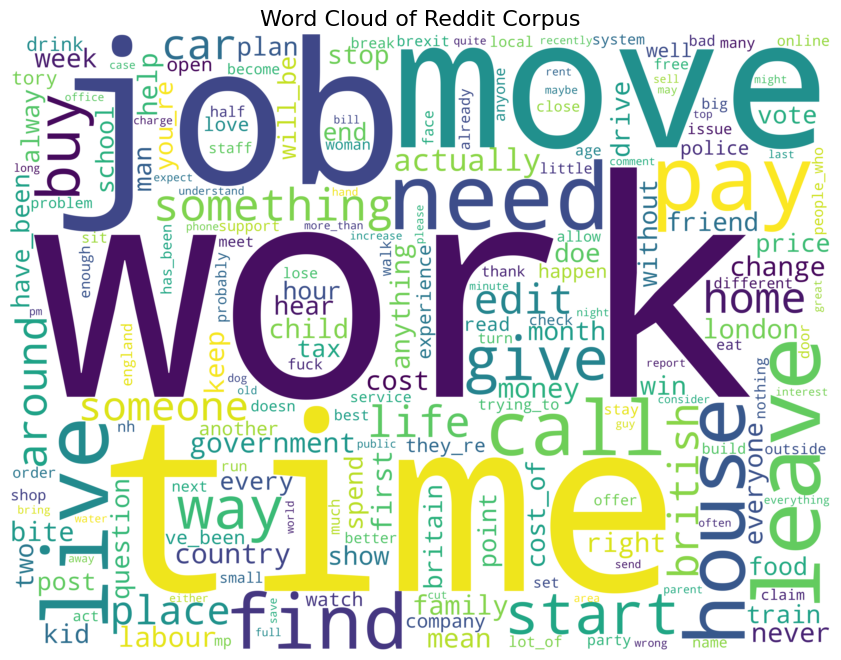

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Flatten your processed tokens into one big list
all_words = [word for doc in df["processed_text_new"] for word in doc]

# Convert to string
all_text = " ".join(all_words)

# Generate word cloud
wc = WordCloud(
    width=2400, height=1800, scale=2,
    background_color="white",
    colormap="viridis",
    max_words=200,
    collocations=False
).generate(all_text)

# Plot
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reddit Corpus", fontsize=16)
plt.show()

# Save high-res version
wc.to_file("reddit_wordcloud.png")


In [0]:
wc.to_file("reddit_wordcloud.png")